In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
# import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

In [10]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255., 
                                   validation_split = 0.10)

train_generator = train_datagen.flow_from_directory(directory = '../image_data/cropped_train/', #저장 경로 
                                                    subset = 'training',   
                                                    batch_size = batch_size,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'binary',
                                                    target_size = (image_size,image_size))

valid_generator = train_datagen.flow_from_directory(directory = '../image_data/cropped_train/',
                                                    subset = 'validation',
                                                    batch_size = batch_size,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'binary',
                                                    target_size = (image_size,image_size))
print(train_generator.n)
print(valid_generator.n)


Found 6446 images belonging to 2 classes.
Found 715 images belonging to 2 classes.
6446
715


In [12]:
train_generator.class_indices

{'negative': 0, 'positive': 1}

In [ ]:
# Make model == feature model
feature_model = load_model('../models/image_models/DenseNet201.h5')


In [13]:
feature_model.output.shape[1:]

TensorShape([7, 7, 1920])

In [ ]:
feature_model.summary()

In [7]:
train_features = [] 
train_Y = []

for idx in tqdm(range(train_generator.n//batch_size+1)): # 2785 

    x, y = train_generator.next() 
    train_Y.extend(y) 
    feature = feature_model.predict(x)
    train_features.extend(feature)

#array 전환 
train_features = np.array(train_features)
train_Y = np.array(train_Y)

print(train_features.shape) 
print(train_Y.shape) 

  0%|          | 0/202 [00:00<?, ?it/s]


NameError: name 'feature_model' is not defined

In [15]:
valid_features = []
valid_Y = []


for idx in tqdm(range(valid_generator.n//batch_size+1)):

    x, y = valid_generator.next() 
    valid_Y.extend(y) 
    feature = feature_model.predict(x)
    valid_features.extend(feature)

#array 전환 
valid_features = np.array(valid_features)
valid_Y = np.array(valid_Y)

print(valid_features.shape)
print(valid_Y.shape)

100%|██████████| 23/23 [00:05<00:00,  4.09it/s]

(715, 7, 7, 1920)
(715,)


In [16]:
# Make Classifier Model
def create_model():
    input = Input(shape=(7,7,1920))
    x = GlobalAveragePooling2D()(input)

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.6)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input, outputs=predictions)

    model.compile(optimizer=Adam(lr=1e-4),loss='binary_crossentropy',metrics=['accuracy'])
    
    return model


# 모델 객체를 만듬
model = create_model()

checkpoint_path = 'testmodel/bestmodel'

checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=7, 
                                   min_lr=1e-6)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited

callbacks_list = [checkpoint, early, reduceLROnPlat]


In [17]:
history = model.fit(train_features, train_Y, 
                    validation_data=(valid_features, valid_Y),
                    epochs = 200,
                    batch_size = batch_size,
                    callbacks=callbacks_list)
model.summary()

Epoch 1/200
196/202 [============================>.] - ETA: 0s - loss: 0.5684 - accuracy: 0.7302
Epoch 00001: val_loss improved from inf to 0.29927, saving model to testmodel/bestmodel
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: testmodel/bestmodel/assets
202/202 [==============================] - 3s 14ms/step - loss: 0.5652 - accuracy: 0.7322 - val_loss: 0.2993 - val_accuracy: 0.9343
Epoch 2/200
195/202 [===========================>..] - ETA: 0s - loss: 0.3472 - accuracy: 0.8853
Epoch 00002: val_loss improved from 0.29927 to 0.25608, saving model to testmodel/bestmodel
INFO:tensorflow:Assets written to: testmodel/bestmodel/assets
202/202 [==============================] - 3s 13ms/step - loss: 0.3465 - accuracy: 0.8855 - val_loss: 0.2561 - val_accuracy: 0.9315
Epoc

In [34]:
model.save('/content/drive/My Drive/인공지능 학습관련/covid_model_2class.h5')

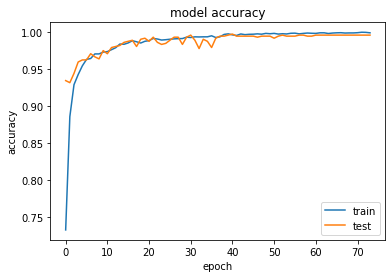

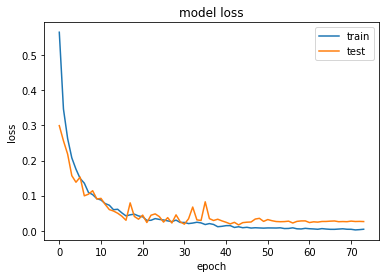

In [18]:
# 모델 acc/loss 그래프

## summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()
## summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

plt.show()

In [22]:
best_model = load_model(checkpoint_path)

# 모델 평가
print(best_model.evaluate(valid_features, valid_Y))
best_model.summary()

23/23 [==============================] - 0s 5ms/step - loss: 0.0166 - accuracy: 0.9944
[0.016648393124341965, 0.9944055676460266]
Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 7, 7, 1920)]      0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1920)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               983552    
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0

In [24]:
best_model.save('Covid_2class.h5')

In [26]:
image_size = 224

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(directory = '../image_data/cropped_test/',
                                                    subset = 'training',   
                                                    batch_size = 1,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'binary',
                                                    target_size = (image_size,image_size))

Found 1127 images belonging to 2 classes.


(1, 299, 299, 3)
non-COVID content


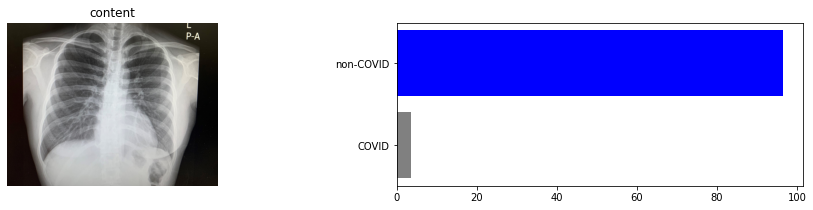

In [9]:
# import random
# import cv2

predictY = []
realY = []
iter = 1
model = model2

unique_sorted_Y = ['COVID','non-COVID']

for i in range(iter): 
    plt.figure(figsize=(16,iter*3))
    # image_path = random.choice(test_generator.filepaths)
    image_path='/content/KakaoTalk_20201023_150029203.jpg'
    
    #출력 범위 설정 
    plt.subplot(iter,2,i*2+1)

    #검증데이터 출력 
    plt.imshow(plt.imread(image_path))

    # split('/')를 통해 나눠진 부분 중 3번째 획득
    real_y = image_path.split('/')[-2]
    # real_y → bluetick 출력 
    #타이틀 출력 
    plt.title(real_y)
    plt.axis('off')
    #unique_sorted_Y 에 저장된 값을 바탕으로 real_y의 위치 값 할당 
    # idx = unique_sorted_Y.index(real_y)
    # idx → ex) 81, ...  

    #예측값 표기
    plt.subplot(iter,2,i * 2+2)

    img_size = (299, 299)
    # 이미지 불러오기 및 이미지 크기 조정
    img = keras.preprocessing.image.load_img(image_path, target_size=img_size)
    # 이미지를 array로 변경
    img = keras.preprocessing.image.img_to_array(img)
    # 각 픽셀값을 0과 1사이의 값으로 조정
    img = img / 255.0
    # 모델의 인풋 타입에 맞게 차원을 하나 늘림
    img = np.expand_dims(img, axis=0)
    print(img.shape)

    #img를 Inception V3의 특징 추출기 feature_model을 활용하여 특징 벡터를 생성. 
    feature_vector = feature_model.predict(img)

    # 앞서 생성한 model 분류기를 통해 예측 수행
    prediction = model.predict(feature_vector)[0]
    
    color = ['gray'] * 2
    if prediction <= 0.5:
        predict = 0
        color[0] = 'blue'
        label = 'COVID'
    else:
        predict = 1
        color[1] = 'blue'
        label = 'non-COVID'

    covid_ratio = float(1-prediction)
    non_ration = float(prediction)

    ratio = np.zeros(2)
    ratio[0] = covid_ratio
    ratio[1] = non_ration

    #가로 막대 그리기 
    plt.barh(range(2), ratio * 100, color = color)
    plt.yticks(range(2), unique_sorted_Y)

    # print(labels[0], realY[0])
    predictY.append(label)
    realY.append(real_y)
    print(label,real_y)
    plt.show()

In [3]:
# 글자만.
import random
# import cv2

predictY = []
realY = []
iteration = 1000
model = model2
unique_sorted_Y = ['negative','positive']

for i in range(iteration): 
    image_path = random.choice(test_generator.filepaths)
    real_y = image_path.split('/')[-2] 

    img_size = (image_size, image_size)
    # 이미지 불러오기 및 이미지 크기 조정
    img = keras.preprocessing.image.load_img(image_path, target_size=img_size)
    # 이미지를 array로 변경
    img = keras.preprocessing.image.img_to_array(img)
    

    # 각 픽셀값을 0과 1사이의 값으로 조정
    img = img / 255.0
    # 모델의 인풋 타입에 맞게 차원을 하나 늘림
    img = np.expand_dims(img, axis=0)
    
    feature_vector = feature_model.predict(img)

    prediction = model.predict(feature_vector)[0]
    # print(prediction)
    if prediction <= 0.5:
        predict = 0
    else:
        predict = 1
    #labels에 저장 
    label = unique_sorted_Y[predict] 
    
    # print(labels[0], realY[0])
    predictY.append(label)
    realY.append(real_y)
    print(label,real_y)

NameError: name 'model2' is not defined

Confusion matrix, without normalization
[[100   7]
 [ 13 880]]


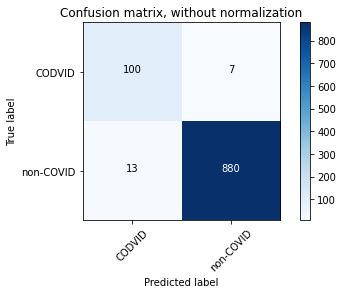

In [47]:
import itertools
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(predictY, realY)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.figure()
plot_confusion_matrix(cm, classes=['CODVID', 'non-COVID'], title='Confusion matrix, without normalization')